# Person Re-ID on Market-1501 (Ranking)

This is for generating a ranked list of images given a trained model and a query image.

First, import required modules. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../' # Expected to be in rank_scripts/

import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os

In [10]:
caffe.set_device(0)
caffe.set_mode_gpu()
net = caffe.Net(caffe_root +  'examples/_temp/imagenet_train.prototxt',
                caffe_root + 'rank_scripts/models1/_iter_100000.caffemodel',
                caffe.TEST)
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'rank_scripts/market_train_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [11]:
# set net to batch size of 50
net.blobs['data'].reshape(50,3,64,64)

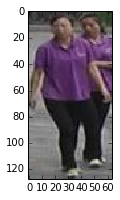

In [12]:
query_image_path = 'rank_scripts/images_market/0026_c2s1_001626_00.jpg'
query_image = caffe.io.load_image(caffe_root + query_image_path)
net.blobs['data'].data[...] = transformer.preprocess('data', query_image)
out = net.forward()
vector_query = out['norml2']
plt.figure(figsize=(3,3))
plt.imshow(query_image)

In [13]:
#getDiff Implementation
def getDiff( vector1, vector2 ):
    sum=0
    for i in range(100):
        for j in range(1024):
            diff= vector1[i][j]-vector2[i][j]
            diff=diff*diff
            sum=sum+diff
        
    return math.sqrt(sum)

In [14]:
#Rank Vector Setup
num_rank = 5 

#Paired list to hold (diff,imagePath)

Rank_list= []

In [15]:
query_folder = caffe_root + 'rank_scripts/images_market/'
images_list = os.listdir(query_folder)
i=10

#print images_list

for image in images_list:
    new_net = caffe.Net(caffe_root +  'examples/_temp/imagenet_train.prototxt',
                caffe_root + 'rank_scripts/models1/_iter_100000.caffemodel',
                caffe.TEST)
    new_net.blobs['data'].reshape(50,3,64,64)
    new_net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(query_folder + image))
    output=new_net.forward()
    vector_new=output['norml2']
    diff = getDiff(vector_query, vector_new)
    
    #add the pair (diff,image) to the list
    Rank_list.append((diff,image))
    
    #sort the list based on diff
    Rank_list.sort()

    #remove the last element if more than 'num_rank'
    if len(Rank_list) > num_rank :
        Rank_list.remove(Rank_list[len(Rank_list)-1])
    
print Rank_list

[(0.013094286070356408, '0001_c5s1_001426_00.jpg'), (0.013343007830726412, '0004_c5s3_066212_00.jpg'), (0.013541880859612823, '0049_c3s1_004976_00.jpg'), (0.013680633013282477, '0001_c3s1_000551_00.jpg'), (0.013697110774470249, '0051_c5s1_005976_00.jpg')]


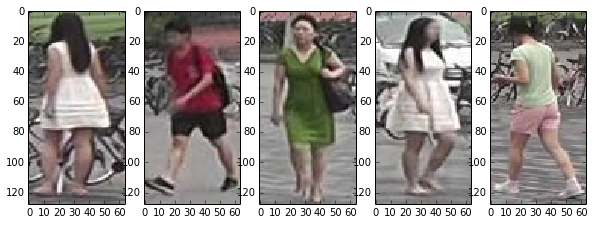

In [18]:
fig,axs = plt.subplots (nrows=1,ncols=len(Rank_list))
i=0

for item in Rank_list:
    new_image_name = item[1]
    new_image = caffe.io.load_image(query_folder + new_image_name)
    
    plt.figure(figsize=(3,3))
    axs[i].imshow(new_image)
    i=i+1